In [1]:
# import pytorch libraries
%matplotlib inline
import matplotlib.pyplot as plt
import torch 
import torch.autograd as autograd 
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
import time
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
import pandas as pd
from ripser import Rips
import persim

In [31]:
device,torch.cuda.is_available()

(device(type='cuda'), True)

# Loading MNIST

In [4]:
BATCH_SIZE = 512

In [5]:
transform=transform=transforms.Compose([
                       transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,)) ]) #,transforms.Normalize((0.1307,), (0.3081,)) using to Normalize doesn't help accuracy it seems.

# Load and transform data
trainset = torchvision.datasets.MNIST('/tmp', train=True, download=False, transform=transform)
testset = torchvision.datasets.MNIST('/tmp', train=False, download=False, transform=transform)

In [6]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=32)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=32)

In [7]:
def train_model(train_loader,num_epochs,model,optimizer):
    for epoch in range(num_epochs):
        model.train()# model is ready to have weights updated
        for i, (images,labels ) in enumerate(train_loader):
            #print(images.shape[2]*images.shape[3]) 
            images = images.view(-1,images.shape[2]*images.shape[3]) # making into a column vector
            images = Variable(images, requires_grad=False).to(device)#.cuda()
            
            labels = labels.type(torch.LongTensor)
            labels = Variable(labels, requires_grad=False).to(device)#.cuda()
            # Forward + Backaward + Optimization
            optimizer.zero_grad()
            y_hat = model(images)
            criterion = nn.CrossEntropyLoss()
            loss = criterion(y_hat,labels)
            loss.backward()
            optimizer.step()

In [8]:
def model_accuracy_loss(model, dataloader):
    model.eval()
    correct = 0
    sum_loss = 0.0
    total = 0
    for images, labels in dataloader:
        images = Variable(images.view(-1, 28*28)).to(device)#.cuda()
        labels = Variable(labels).to(device)#.cuda()
       
        outputs = model(images)
        _, pred = torch.max(outputs.data, 1)# gives maxes and indices locations
        loss = F.cross_entropy(outputs, labels)
        sum_loss += labels.size(0)*loss.item()
        total += labels.size(0)
        correct += pred.eq(labels.data).cpu().sum() 
    return 100 *correct / total

In [9]:
def train_and_eval(model,num_epochs,optimizer,dataloader,isTrain=True):
    """
    This function trains and then immediately evaluates the model 
    on the MNIST database.
    """
    if isTrain:
        train_model(trainloader,num_epochs,model,optimizer)
    accuracy = model_accuracy_loss(model,dataloader)
    
    return float(accuracy.item())

In [10]:
def run_experiment(activation_fns, num_epochs, num_runs, activation_acc_results,activation_names ,dataloader,isTrain=True):
    # Our constant structure :
    # Input: 784 Neurons
    # H1 : 256
    # H2 : 128
    # Output : 10
    for run in range(num_runs):
        if run%5==0:
              print("Run: "+str(run)+" Epoch: "+str(num_epochs))
        for i in range(len(activation_names)):
            act_name = activation_names[i]
            experiment_model = create_swish_model(256,128,activation_fns[act_name])
            if isTrain:
                experiment_model.load_state_dict(torch.load('experiment weights/experiment_model_'+str(run)))
            else:
                experiment_model.load_state_dict(torch.load('trained weights/'+act_name+'experiment_model_'+str(run)+str(num_epochs)))
            if use_cuda and torch.cuda.is_available():
                experiment_model.cuda()
                
            #Hyper Params constant for this experiment
            learning_rate = 0.01
            optimizer = torch.optim.Adam(experiment_model.parameters(), lr=learning_rate)
            acc = train_and_eval(experiment_model,num_epochs,optimizer,dataloader,isTrain)
            torch.save(experiment_model.state_dict(), 'trained weights/'+act_name+'experiment_model_'+str(run)+str(num_epochs))
            activation_acc_results[act_name].append(acc)
    return activation_acc_results

# Creating a Distance Matrix

In [11]:
def create_model(H1,H2,activation):
    model = nn.Sequential(nn.Linear(28*28,H1,bias=False),
                               activation(),
                              nn.Linear(H1,H2,bias=False),
                              activation(),
                               nn.Linear(H2,10,bias=False))
    return model.to(device)

In [12]:
#Check if matrix is symmetric
def check_symmetric(a, rtol=1e-05, atol=1e-08):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)

# Steps:
    * Create a model
    * Get that model's weights
    * for each node in the network, get the weights associated with it. (We are ignoring the biases atm)
    * put (1-weights) into the weight matrix
    

In [13]:
# function to create initial distance matrix for a vanilla neural network
def make_dist_mat(model,output_dims):
    dims = 0
    for name,param in model.named_parameters():
        dims+=param.cpu().detach().numpy().shape[1]
    dims+= output_dims
    distance_mat = np.zeros((dims,dims))
    distance_mat += 2.# setting large distance
    # setting diagonal to 0
    for i in range(len(distance_mat)):
        distance_mat[i,i] = 0.
    return distance_mat

In [14]:
def weight_parameters(model):
    # we do 1-weights ,since some weights are negative. We do this to keep all weights within the range 
    # 1~2.
    parameters = [] 
    for name,param in model.named_parameters():
        parameters.append(1-param.cpu().detach().numpy())
    return parameters

In [15]:
# function to build distance matrix based on model parameters.
def build_dist_mat(dist_mat, params, inp_dim, sec_dim, third_dim, out_dim):
    first_zero_blocks = inp_dim
    
    #1st layer by column
    layer_1_dim = params[0].shape#(256,784)
    # (num neurons current layer, cur num neurons+num neurons next layer)
    dist_mat[first_zero_blocks:first_zero_blocks+layer_1_dim[0], 
                 :layer_1_dim[1]] = params[0]
    
    # 2nd layer by column
    second_zero_blocks = sec_dim#(256,256)
    layer_2_dim = parameters[1].shape
    dist_mat[:first_zero_blocks, 
                  first_zero_blocks:layer_1_dim[0]+first_zero_blocks] = params[0].T

    dist_mat[first_zero_blocks+layer_1_dim[0]:first_zero_blocks+layer_1_dim[0]+layer_2_dim[0]
             ,first_zero_blocks:layer_1_dim[0]+first_zero_blocks] = params[1]
    
    # 3rd layer by column
    third_zero_blocks = third_dim #(128,128) these zero matricies should be square
    layer_3_dim = parameters[2].shape
    dist_mat[first_zero_blocks:first_zero_blocks+layer_2_dim[1], 
                 first_zero_blocks+second_zero_blocks:first_zero_blocks
                 +second_zero_blocks+third_zero_blocks] = params[1].T

    dist_mat[first_zero_blocks+second_zero_blocks+third_zero_blocks:,
                first_zero_blocks+second_zero_blocks:
                 first_zero_blocks+second_zero_blocks+third_zero_blocks] = params[2]
    # 4th layer by column
    fourth_zero_blocks = out_dim
    dist_mat[first_zero_blocks+second_zero_blocks:first_zero_blocks
                 +second_zero_blocks+third_zero_blocks,
                 first_zero_blocks
                 +second_zero_blocks+third_zero_blocks:] = params[2].T
    return dist_mat

# Non trained Persistence Diagram

In [ ]:
r = Rips()

In [ ]:
start = time.time()
not_train_diagram = r.fit_transform(distance_mat,distance_matrix=True)
end = time.time()
print("Elapsed: "+str((end-start)/60.)+" minutes")

In [ ]:
r.plot([pd_load['pd'][0],pd_load['pd'][1]], show=True)

# Saving Distance Matricies and PD intervals to file

In [17]:
num_models = 50
num_epochs = 5#n-1
first_layer_dim = 256#10
second_layer_dim = 128#8
model_performances = {}
r = Rips(maxdim=0)

Rips(maxdim=0, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


In [18]:
start = time.time()
for i in range(num_models):
    name = 'model_'+str(i)+'_ne-'+str(0)
    PATH = 'experiment_data/model_params/'+'model_'+str(i)
    model = create_model(first_layer_dim,second_layer_dim,nn.ReLU)
    torch.save(model.state_dict(), PATH)
    
    distance_mat = make_dist_mat(model,10)# 10 = out_dim
    parameters = weight_parameters(model)
    distance_mat = build_dist_mat(distance_mat,parameters,784,first_layer_dim,second_layer_dim,10)
    
    #accuracy before training
    model_performances[name] = [model_accuracy_loss(model,testloader).item()]
    #save dist_mat before training
    np.savez('experiment_data/distance_matricies/not-trained/dist_mat-'+name, dist_mat=distance_mat)
    
    #saving pd diagram
    if check_symmetric(distance_mat): 
        not_train_diagram = r.fit_transform(distance_mat,distance_matrix=True)
        np.savez('experiment_data/pd_intervals/not-trained/pd-'+name, pd=not_train_diagram)
    
    for e in range(num_epochs):
        model.load_state_dict(torch.load(PATH))
        name = 'model_'+str(i)+'_ne-'+str(e+1) # name after training
        # now train the model
        optimizer = optim.Adam(model.parameters())
        train_and_eval(model,e+1,optimizer,trainloader)
        #performance after training
        model_performances[name] = [model_accuracy_loss(model,testloader).item()]
        
        #new dist mat after training
        parameters = weight_parameters(model)
        distance_mat = build_dist_mat(distance_mat,parameters,784,first_layer_dim,second_layer_dim,10)
        #save dist_mat after training
        np.savez('experiment_data/distance_matricies/trained/dist_mat-'+name, dist_mat=distance_mat)
        #saving pd diagram
        if check_symmetric(distance_mat): 
            train_diagram = r.fit_transform(distance_mat,distance_matrix=True)
            np.savez('experiment_data/pd_intervals/trained/pd-'+name, pd=train_diagram)
end = time.time()
print("Elapsed Experiment Time: "+str((end-start)/60.)+" minutes")

Elapsed Experiment Time: 32.459229334195456 minutes


In [22]:
# Should also record accuracy for each network before and after training and 
#how many epochs a model was training for
pd.DataFrame(data=model_performances,index=['Accuracy']).to_csv('experiment_data/model_accuracies.csv')

{'model_0_ne-0': [10],
 'model_0_ne-1': [93],
 'model_0_ne-2': [95],
 'model_0_ne-3': [96],
 'model_0_ne-4': [97],
 'model_0_ne-5': [97],
 'model_1_ne-0': [9],
 'model_1_ne-1': [94],
 'model_1_ne-2': [96],
 'model_1_ne-3': [96],
 'model_1_ne-4': [97],
 'model_1_ne-5': [97],
 'model_2_ne-0': [11],
 'model_2_ne-1': [93],
 'model_2_ne-2': [95],
 'model_2_ne-3': [96],
 'model_2_ne-4': [97],
 'model_2_ne-5': [97],
 'model_3_ne-0': [14],
 'model_3_ne-1': [93],
 'model_3_ne-2': [95],
 'model_3_ne-3': [96],
 'model_3_ne-4': [96],
 'model_3_ne-5': [97],
 'model_4_ne-0': [13],
 'model_4_ne-1': [94],
 'model_4_ne-2': [95],
 'model_4_ne-3': [96],
 'model_4_ne-4': [96],
 'model_4_ne-5': [97],
 'model_5_ne-0': [5],
 'model_5_ne-1': [93],
 'model_5_ne-2': [95],
 'model_5_ne-3': [96],
 'model_5_ne-4': [97],
 'model_5_ne-5': [97],
 'model_6_ne-0': [10],
 'model_6_ne-1': [94],
 'model_6_ne-2': [96],
 'model_6_ne-3': [96],
 'model_6_ne-4': [97],
 'model_6_ne-5': [97],
 'model_7_ne-0': [6],
 'model_7_ne-1

In [ ]:
np.savez('experiment_data/distance_matricies/not-trained/dist_mat',lol=distance_mat)


In [ ]:
d_mat = np.load('experiment_data/distance_matricies/not-trained/dist_mat.npz')

In [ ]:
d_mat['lol']

In [ ]:
np.savez('experiment_data/distance_matricies/not-trained/not_train_pd',pd=not_train_diagram)

In [26]:
pd_load = np.load('experiment_data/pd_intervals/not-trained/pd-model_0_ne-0.npz')

In [27]:
pd_load['pd'][0]


array([[0.        , 0.91172481],
       [0.        , 0.91190767],
       [0.        , 0.91191262],
       ...,
       [0.        , 0.96605211],
       [0.        , 0.96649766],
       [0.        ,        inf]])

# train a model then persistence

In [32]:
trained_model = create_model(first_layer_dim,second_layer_dim,nn.ReLU)
optimizer = optim.Adam(trained_model.parameters())

RuntimeError: cuda runtime error (4) : unspecified launch failure at /opt/conda/conda-bld/pytorch_1535493744281/work/aten/src/THC/generic/THCTensorCopy.cpp:20

In [33]:
#before train
model_accuracy_loss(trained_model,testloader)

NameError: name 'trained_model' is not defined

In [ ]:
train_and_eval(trained_model,0,optimizer,trainloader)

In [ ]:
model_accuracy_loss(trained_model,testloader)

In [ ]:
train_distance_mat = make_dist_mat(trained_model,10)
parameters = weight_parameters(trained_model)
train_distance_mat = build_dist_mat(train_distance_mat,parameters,784,first_layer_dim,second_layer_dim,10)
train_distance_mat

In [ ]:
train_distance_mat[785]

In [ ]:
#plt.imshow(train_distance_mat)

In [ ]:
check_symmetric(train_distance_mat)

In [ ]:
start = time.time()
train_pd = r.fit_transform(train_distance_mat, distance_matrix=True)
end = time.time()
print("Elapsed: "+str((end-start)/60.)+" minutes")

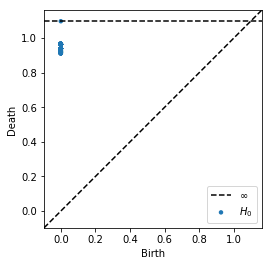

In [28]:
r.plot(pd_load['pd'][0], show=True)

In [ ]:
start = time.time()
print(persim.bottleneck(train_pd[0], not_train_diagram[0])) #H_0
end = time.time()
print("Elapsed: "+str((end-start)/60.)+" minutes")

In [ ]:
train_pd[1].shape

In [ ]:
#H_1 gives a memory error too many simplicies around 230k
start = time.time()
print(persim.bottleneck(train_pd[1][:1000], not_train_diagram[1][:1000])) #H_1 distance
end = time.time()
print("Elapsed: "+str((end-start)/60.)+" minutes")

In [ ]:
# path homology for direct graph homology
# directed clique homology no software avail
# can look at homology fluctates per epoch
# find bottleneck distance